In [32]:
def define_plot_resolution():
    fig = plt.gcf()  # get current figure0

    DPI = fig.get_dpi()
#     fig.set_size_inches(1920.0 / float(DPI), 1080.0 / float(DPI))
    fig.set_size_inches(12, 8)
    ax = plt.gca()
    for tickLabel in ax.get_xticklabels()+ax.get_yticklabels():
        tickLabel.set_fontsize(29)
    ax.yaxis.label.set_size(29)
    ax.xaxis.label.set_size(29)
    ax.yaxis.offsetText.set_fontsize(29)
    ax.xaxis.offsetText.set_fontsize(29)
    return


In [50]:
import mpmath as mp
from mpmath import *
import numpy as np
import pandas as pd
import time

mp.dps = 500
mp.prec = 166

lnMpinGev = mp.mpf('42.334')
Mp = mp.exp(lnMpinGev)

def norm_potential(x,alpha,phi0):
    return x**mp.mpf('2')-mp.mpf('2')/3*alpha*x**6+alpha/mp.mpf('5')*x**10

def norm_eps1(x,alpha,phi0):
    return mp.mpf('450')*(mp.mpf('1')+alpha*x**4*(-mp.mpf('2')+x**4))**2/((phi0*x)**mp.mpf('2')*(mp.mpf('15')+alpha*x**4*(-mp.mpf('10')+mp.mpf('3')*x**4))**2)

def norm_eps2(x,alpha,phi0):
    return (mp.mpf('60')*(mp.mpf('15')+alpha*x**mp.mpf('4')*(mp.mpf('40')+x**mp.mpf('4')*(-mp.mpf('78')+alpha*(mp.mpf('20')+mp.mpf('3')*x**8)))))/(phi0**2*x**2*(mp.mpf('15')+alpha*x**mp.mpf('4')*(-mp.mpf('10')+mp.mpf('3')*x**4))**2)
       
def norm_eps3(x,alpha,phi0):
    return (mp.mpf('60')*(mp.mpf('1')+alpha*x**4*(-mp.mpf('2')+x**mp.mpf('4')))*(mp.mpf('225')+alpha*x**mp.mpf('4')*(-mp.mpf('1350')+x**4*(mp.mpf('3915')+alpha*(-mp.mpf('2100')+mp.mpf('20')*(mp.mpf('81')-mp.mpf('10')*alpha)*x**4+mp.mpf('15')*(-mp.mpf('99')+mp.mpf('20')*alpha)*x**mp.mpf('8')+mp.mpf('90')*alpha*x**mp.mpf('12')+mp.mpf('9')*alpha*x**16)))))/(x**2*(mp.mpf('15')+alpha*x**mp.mpf('4')*(-mp.mpf('10')+mp.mpf('3')*x**4))**2*(mp.mpf('15')+alpha*x**4*(mp.mpf('40')+x**4*(-mp.mpf('78')+alpha*(mp.mpf('20')+mp.mpf('3')*x**8)))))/phi0**2

def x_endinf(alpha,phi0):
    xstart = mp.mpf('0.9841521')
    return mp.findroot(lambda x : norm_eps1(x,alpha,phi0)-mp.mpf('1'), xstart,solver='halley', verbose = False)

def efold_primitive(x,alpha,phi0):
    aplus=-alpha+mp.sqrt((alpha**2-alpha)*mp.mpc('1','0'))
    aminus=-alpha-mp.sqrt((alpha**2-alpha)*mp.mpc('1','0'))
    bplus=mp.mpf('2')*(aplus+alpha/mp.mpf('3'))/(aplus-aminus)
    bminus=mp.mpf('2')*(aminus+alpha/mp.mpf('3'))/(aminus-aplus)
    return phi0**2*(mp.re(x**2/20+bplus/(10*mp.sqrt(aplus))*mp.atan(mp.sqrt(aplus)*x**2)+bminus/(10*mp.sqrt(aminus))*mp.atan(mp.sqrt(aminus)*x**2)))

def get_calfconst_rrad(lnRrad,Pstar,epsEnd,potEnd):
    cmbMeasuredQuart = mp.mpf('0.25')*mp.log(Pstar*mp.mpf('8')*mp.pi**2)
    kstar, lnMpcToKappa, HubbleSquareRootOf3OmegaRad, RelatDofRatio = mp.mpf('0.05'), mp.mpf('130.282'), mp.mpf('7.5437e-63'), mp.mpf('1')
    N0 = mp.log(kstar) - lnMpcToKappa - mp.mpf('0.5')*mp.log(HubbleSquareRootOf3OmegaRad) - mp.mpf('0.25')*mp.log(RelatDofRatio)
    return - N0 + cmbMeasuredQuart-mp.mpf('0.25')*mp.log(potEnd/(mp.mpf('3')-epsEnd)) + lnRrad

def x_rrad(alpha,phi0,lnRrad,Pstar):
    xEnd = x_endinf(alpha,phi0)
    epsOneEnd = norm_eps1(xEnd,alpha,phi0)
    potEnd = norm_potential(xEnd,alpha,phi0)
    primEnd = efold_primitive(xEnd,alpha,phi0)
    calF = get_calfconst_rrad(lnRrad,Pstar,epsOneEnd,potEnd)
    calFplusNuEnd = calF+primEnd
    x_eps10 = 1
    return mp.findroot(lambda x : find_x_rrad(x, alpha, phi0,calFplusNuEnd), mp.mpf('1'), solver='halley', verbose = False)

def find_reheat_rrad_leadorder(nuStar,calFplusNuEnd,epsOneStar,Vstar):
    return nuStar - calFplusNuEnd + mp.mpf('0.25')*mp.log(mp.mpf('9')/(epsOneStar*Vstar))

def find_x_rrad(x,alpha,phi0,calFplusNuEnd):
    nuStar = efold_primitive(x,alpha,phi0)
    epsOneStar = norm_eps1(x,alpha,phi0)
    Vstar = norm_potential(x,alpha,phi0)
    res = find_reheat_rrad_leadorder(nuStar,calFplusNuEnd,epsOneStar,Vstar)
    return res

def ns_from_alpha(alpha, phi0B, lnRrad, Pstar):
    phi0 = phi0B*((5*alpha+mp.sqrt(mp.mpf('25')*alpha**2-mp.mpf('9')))/(9*alpha))**(-mp.mpf('0.25'))
    xstar = x_rrad(alpha, phi0, lnRrad, Pstar)
    return mp.mpf('1')-2*norm_eps1(xstar, alpha, phi0)-norm_eps2(xstar, alpha, phi0)

def alpha_coeff(phi0_B,lnRrad):
    phi0_B_Vec=[0.000001,0.000003,0.00001,0.0001,0.001,0.01,0.1]
#     if lnRrad == 0:
    coeff_Vec=[2.5,2.2,2.05,1.7,1.4,1.2,1.]
#     elif lnRrad == -10:
#       coeff_Vec=[5.2,4.4,3.8,3.,2.4,2.,1.6]
    i=0
    while(phi0_B > phi0_B_Vec[i] and i < 5):
        i=i+1
    i = i-1
    return coeff_Vec[i]+(coeff_Vec[i+1]-coeff_Vec[i])*mp.log(phi0_B/phi0_B_Vec[i])/mp.log(phi0_B_Vec[i+1]/phi0_B_Vec[i])

def alpha_from_phi0B_and_ns(phi0B, ns, lnRrad,Pstar):
    alpha_min = mp.mpf('1')-alpha_coeff(phi0B,lnRrad)*phi0B**4*mp.pi**2/(mp.mpf('900')*mp.mpf('50')**2)
    alpha_max = mp.fsub(mp.mpf('1'),mp.mpf('1e-30'))
    return mp.findroot(lambda alpha : ns_from_alpha(alpha, phi0B, lnRrad, Pstar)-ns, (alpha_min, alpha_max), solver='anderson', verbose=False)

def aspic(lnRrad, ns_f, phi0_input, Pstar):
    phi0B_list, phistar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list, alphas_list = [], [], [], [], [], [], [], [], []
    nphi0 = len(phi0_input)
    for i, phi0B in enumerate(phi0_input):
#         start = time.process_time()

        alpha = alpha_from_phi0B_and_ns(phi0B/Mp, ns_f, lnRrad, Pstar)
        phi0 = phi0B*((5*alpha+mp.sqrt(mp.mpf('25')*alpha**2-mp.mpf('9')))/(9*alpha))**(-mp.mpf('0.25'))
        xstar = x_rrad(alpha, phi0/Mp, lnRrad, Pstar)
        eps1 = norm_eps1(xstar,alpha,phi0/Mp)
        eps2 = norm_eps2(xstar,alpha,phi0/Mp)
        eps3 = norm_eps3(xstar,alpha,phi0/Mp)
        
        ns, r, alpha_s = 1 - 2*eps1 - eps2, 16*eps1, -2*eps1*eps2-eps2*eps3
        M = (Pstar * 8 * mp.pi**2 * Mp**2 * eps1 * 3 * Mp**2 / norm_potential(xstar,alpha,phi0/Mp))**mp.mpf('0.25')
        mphiBoehm2 = 2 * M**4 / (phi0)**2 
        AB=mp.sqrt(80*alpha)*M**2/(phi0)
        lambdaB=Mp**3*mp.sqrt(alpha/5)*M**2/(phi0)**5
 
        phi0B_list.append(phi0B)
        phistar_list.append(xstar*phi0)
        alpha_list.append(alpha)
        mphi_list.append(mphiBoehm2**0.5)
        A6_list.append(AB)
        lambda6_list.append(lambdaB)
        ns_list.append(ns)
        r_list.append(r)
        alphas_list.append(alpha_s)

#     print('□', end='')
    return phi0B_list, phistar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list, alphas_list


def equ(phi0_input, Pstar_list, ns_list, lnRrad_list):
    x_lnRrad, x_Pstar,x_ns, y_mphi, y_alpha, y_A6, y_lambda6 = [], [], [], [], [], [], []
    for Pstar in Pstar_list:
        for ns in ns_list:
            for lnRrad in lnRrad_list:
                try:
                    phi0B_list, phistar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list, alphas_list = aspic(lnRrad, ns, phi0_input, Pstar)
                except:
                    phi0B_list, phistar_list, alpha_list, mphi_list, A6_list, lambda6_list, ns_list, r_list, alphas_list = [np.nan], [np.nan], [np.nan], [np.nan], [np.nan], [np.nan], [np.nan], [np.nan]
                y_mphi.append(mphi_list[0])
                y_alpha.append(alpha_list[0])
                y_A6.append(A6_list[0])
                y_lambda6.append(lambda6_list[0])
                x_Pstar.append(Pstar)
                x_ns.append(ns)
                x_lnRrad.append(lnRrad)
    return x_Pstar, x_ns, x_lnRrad, y_mphi, y_alpha, y_A6, y_lambda6



Je fais un pavage dans le plan ns lnRrad des paramètres à un phi0 donné pour voir si y aurait pas une relation linéaire entre les deux

In [51]:
phi0_input = [mp.mpf('7e14')]
lnRrad_list = np.arange(-12, 0, 1)
Pstar_list = [mp.mpf('2.0989031673191437e-9')]
ns_list = np.arange(0.91, 0.99, 0.01)
x_Pstar, x_ns, x_lnRrad, y_mphi, y_alpha, y_A6, y_lambda6 = equ(phi0_input, Pstar_list, ns_list, lnRrad_list)

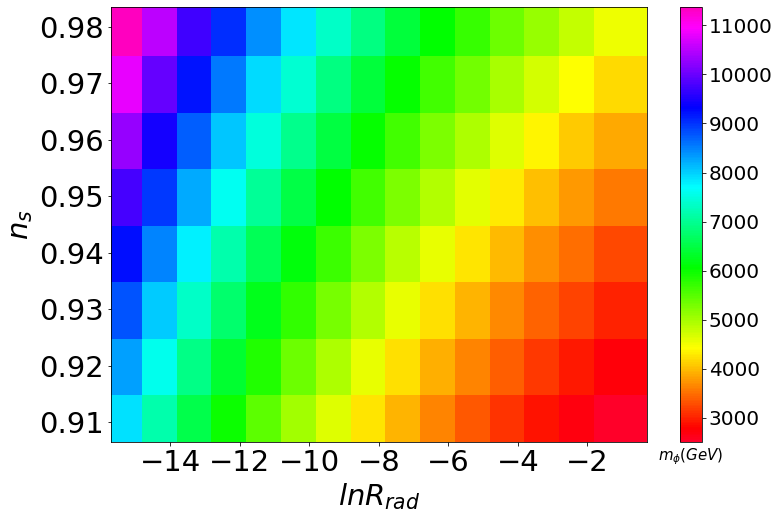

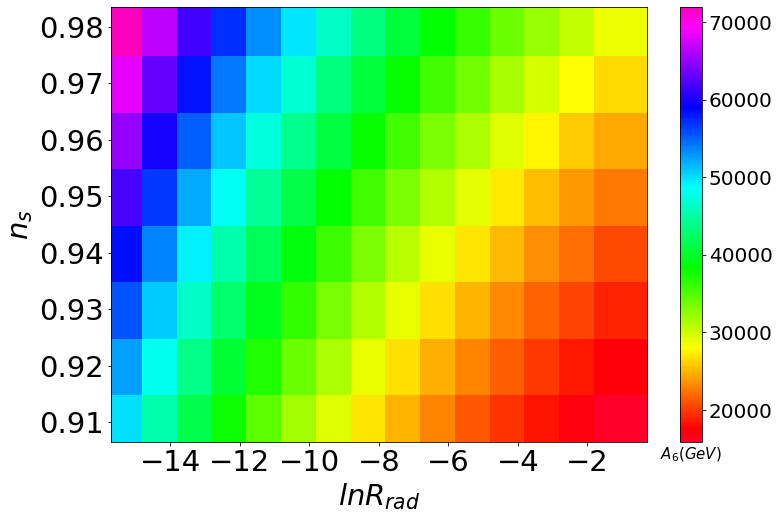

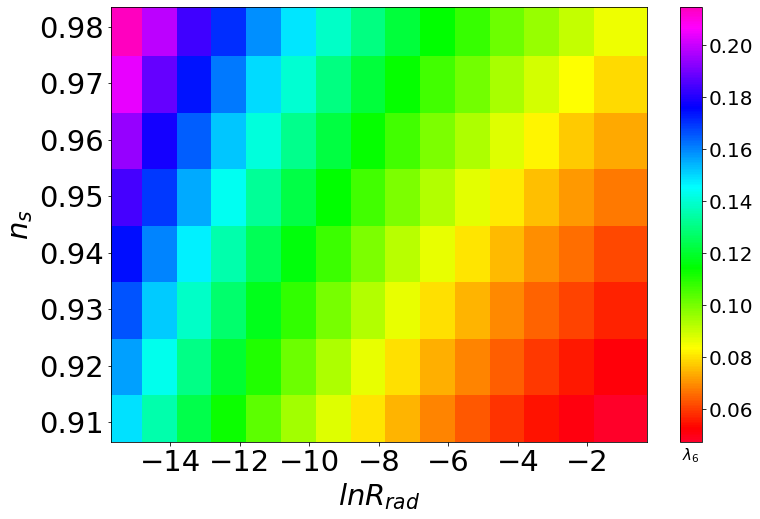

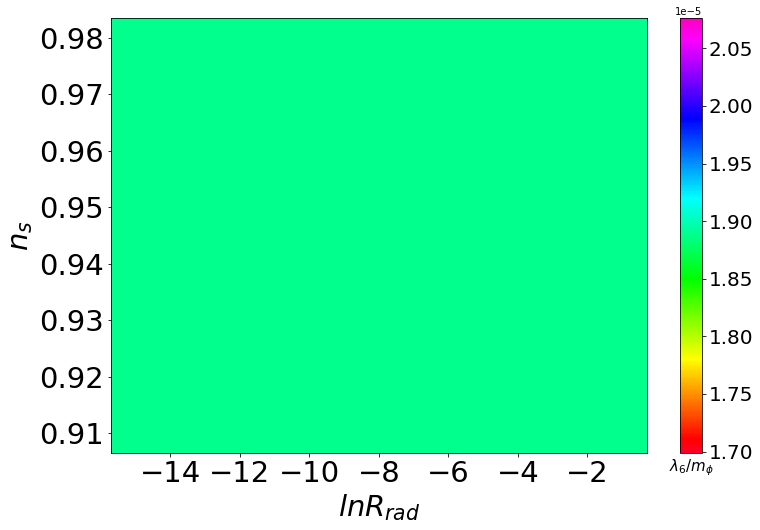

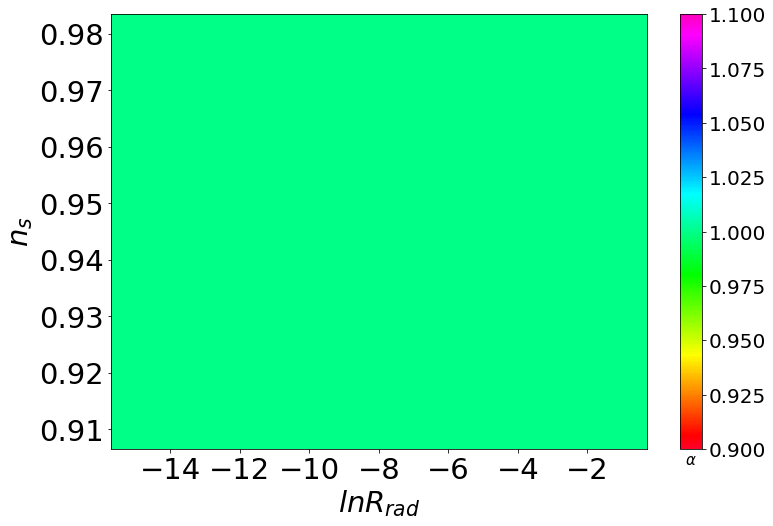

In [86]:
plt.figure(1)
plt.scatter(x_lnRrad, x_ns, c=y_mphi, cmap = 'gist_rainbow', marker = 's', s=3200)
bar = plt.colorbar()
plt.ylabel(r'$n_s$')
plt.xlabel(r'$lnR_{rad}$')
bar.ax.tick_params(labelsize=20) 
bar.ax.set_xlabel(r'$m_\phi (GeV)$',fontsize=15, family='serif')
define_plot_resolution()

plt.figure(2)
plt.scatter(x_lnRrad, x_ns, c=y_A6, cmap = 'gist_rainbow', marker = 's', s=3200)
bar = plt.colorbar()
bar.ax.tick_params(labelsize=20) 
bar.ax.set_xlabel(r'$A_6 (GeV)$',fontsize=15, family='serif')
plt.ylabel(r'$n_s$')
plt.xlabel(r'$lnR_{rad}$')
define_plot_resolution()

plt.figure(3)
plt.scatter(x_lnRrad, x_ns, c=y_lambda6, cmap = 'gist_rainbow', marker = 's', s=3200)
bar = plt.colorbar()
bar.ax.tick_params(labelsize=20) 
bar.ax.set_xlabel(r'$\lambda_6$',fontsize=15, family='serif')
plt.ylabel(r'$n_s$')
plt.xlabel(r'$lnR_{rad}$')
define_plot_resolution()

plt.figure(4)
plt.scatter(x_lnRrad, x_ns, c=np.array(y_lambda6)/np.array(y_mphi), cmap = 'gist_rainbow', marker = 's', s=3200)
bar = plt.colorbar()
bar.ax.tick_params(labelsize=20) 
bar.ax.set_xlabel(r'$\lambda_6/m_\phi$',fontsize=15, family='serif')
plt.ylabel(r'$n_s$')
plt.xlabel(r'$lnR_{rad}$')
define_plot_resolution()

plt.figure(5)
plt.scatter(x_lnRrad, x_ns, c=y_alpha, cmap = 'gist_rainbow', marker = 's', s=5000)
bar = plt.colorbar()
bar.ax.tick_params(labelsize=20) 
bar.ax.set_xlabel(r'$\alpha$',fontsize=15, family='serif')
plt.ylabel(r'$n_s$')
plt.xlabel(r'$lnR_{rad}$')
define_plot_resolution()



1, 2, 3 : cool ca semple etre a vu de nez linéaire

4, 5 : attendu (car les relations flat inflection), et cool (le choix de mphi, A, ou lambda pour calibrer une relation lnRrad-ns sera sans importance)


Etablit une relation linéaire entre lnRrad et ns de telle manière qu'on peut encoder 3 sigmas sur ns dans lnRrad

In [92]:
def lnRrad2(phi0, lnRrad1, ns1, ns2, As):
    mphi_start = aspic(lnRrad1, ns1, [phi0], As)[3][0]
    mphi = lambda lnRrad : aspic(lnRrad, ns2, [phi0], As)[3][0]
    lnRrad_eq = mp.findroot(lambda lnRrad : mphi(lnRrad)-mphi_start, lnRrad1, verbose = False, tol=1e-5)
    return lnRrad_eq

def lnRrad_ns_relation(phi0, lnRrad1, ns1, ns2, As):
    lnRrad2_res = lnRrad2(phi0, lnRrad1, ns1, ns2, As)
    A = (lnRrad2_res-lnRrad1)/(ns2-ns1)
    B = lnRrad1-A*ns1
#     print('0 =', B-lnRrad2_res+A*ns2)
    B_09653 = B+A*0.9653
    return A, B_09653

def determine_lnRrad_eq_wrt_09653(ns, phi0, lnRrad1, ns1, ns2, As):
    A, B = lnRrad_ns_relation(phi0, lnRrad1, ns1, ns2, As)
    return A*(ns-0.9653)+B



# lnRrad2_res = lnRrad2(phi0, lnRrad1, ns1, ns2, As)
# print(lnRrad2_res)
print('A 7e14 GeV:')
A, B = lnRrad_ns_relation(phi0, lnRrad1, ns1, ns2, As)
print('lnRrad =',nstr(A, 4),'(ns - 0.9653) +', nstr(B, 4))


print('\nJ\'essaie d\'évaluer lnRrad équivalent à 3 sigmas sur ns, avec différents phi0 qui calibrent la relation lnRrad-ns')
ns = 0.9776

phi0 = mp.mpf('7e14')
lnRrad1 = 0
As = mp.mpf('2.0989031673191437e-9')
ns1 = 0.94
ns2 = 0.99
lnRrad_eq_plus3sigmas = determine_lnRrad_eq_wrt_09653(ns, phi0, lnRrad1, ns1, ns2, As)
print('\nlnRrad_eq(phi0 = '+nstr(phi0, 3)+') =',nstr(lnRrad_eq_plus3sigmas, 4))


phi0 = mp.mpf('7e15')
lnRrad1 = 0
As = mp.mpf('2.0989031673191437e-9')
ns1 = 0.94
ns2 = 0.99
lnRrad_eq_plus3sigmas = determine_lnRrad_eq_wrt_09653(ns, phi0, lnRrad1, ns1, ns2, As)
print('lnRrad_eq(phi0 = '+nstr(phi0, 3)+') =',nstr(lnRrad_eq_plus3sigmas, 4))

phi0 = mp.mpf('7e16')
lnRrad1 = 0
As = mp.mpf('2.0989031673191437e-9')
ns1 = 0.94
ns2 = 0.99
lnRrad_eq_plus3sigmas = determine_lnRrad_eq_wrt_09653(ns, phi0, lnRrad1, ns1, ns2, As)
print('lnRrad_eq(phi0 = '+nstr(phi0, 3)+') =',nstr(lnRrad_eq_plus3sigmas, 4))


A 7e14 GeV:
lnRrad = 253.8 (ns - 0.9653) + 6.421

J'essaie d'évaluer lnRrad équivalent à 3 sigmas sur ns, avec différents phi0 qui calibrent la relation lnRrad-ns

lnRrad_eq(phi0 = 7.0e+14) = 6.82
lnRrad_eq(phi0 = 7.0e+15) = 8.116
lnRrad_eq(phi0 = 7.0e+16) = 9.543


Ce qui est susceptible de faire changer cette relation :

    Le phi0 auquel elle est évaluée
    
    Les ns entre lesquels elle est calibrée (et ptetre le lnRrad1) => non linéarité..
    
    Si on fait vis a vis de mphi, A6 ou lambda6 (je dirais que sans importance a tree, à cause des flat inflection conds)
   
En effet, ça a l'air d'être le cas. Pas cool. Mais je vais encore regarder